In [1]:
import os
os.getcwd()


'/workspace/ab-testing-simulation/notebooks'

## Data & Group Overview

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

plt.style.use('ggplot')

In [3]:
# Loading and examining the dataset
df = pd.read_csv('/workspace/ab-testing-simulation/data/ab_test_data.csv')
df.head()

,user_id,group,converted,session_duration,pages_viewed,device_type,revenue
0,1,A,0,125,3,mobile,0.00
1,2,A,1,79,2,desktop,41.13
2,3,A,0,131,1,mobile,0.00
3,4,A,0,138,1,tablet,0.00
4,5,A,0,136,1,desktop,0.00


In [4]:
# Checking for missing values and viewing summary statistics

df.info()
df.describe().transpose().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           2000 non-null   int64  
 1   group             2000 non-null   object 
 2   converted         2000 non-null   int64  
 3   session_duration  2000 non-null   int64  
 4   pages_viewed      2000 non-null   int64  
 5   device_type       2000 non-null   object 
 6   revenue           2000 non-null   float64
dtypes: float64(1), int64(4), object(2)
memory usage: 109.5+ KB


,count,mean,std,min,25%,50%,75%,max
user_id,2000.0,1000.50,577.49,1.0,500.75,1000.5,1500.25,2000.00
converted,2000.0,0.13,0.33,0.0,0.00,0.0,0.00,1.00
session_duration,2000.0,128.72,31.14,19.0,108.00,128.0,150.00,236.00
pages_viewed,2000.0,3.47,1.86,1.0,2.00,3.0,5.00,13.00
revenue,2000.0,4.35,11.99,0.0,0.00,0.0,0.00,59.92


In [5]:
# Checking user distribution among test groups
df['group'].value_counts()

group
A    1000
B    1000
Name: count, dtype: int64

In [6]:
# Descriptive Statistics / Performance Metrics overview by group

group_summary = df.groupby('group').agg({
    'user_id': 'count',
    'revenue': ['mean', 'median', 'std'],
    'session_duration': ['mean', 'median', 'std']
})

group_summary.columns = ['_'.join(col) for col in group_summary.columns]
group_summary.reset_index(inplace=True)
group_summary.round(2)


,group,user_id_count,revenue_mean,revenue_median,revenue_std,session_duration_mean,session_duration_median,session_duration_std
0,A,1000,4.25,0.0,11.90,122.46,122.0,29.67
1,B,1000,4.45,0.0,12.08,134.98,134.0,31.33


#### User Counts:

- Group A and Group B have the same number of users (perfectly balanced sample sizes).

#### Revenue & Session Duration:

- Group B shows a slightly higher average in both revenue and session duration compared to Group A.

#### Distribution Shape:

- Revenue is positively skewed (in favour of Group B), likely due to some outliers in terms of a few users spending more than others (a common pattern in e-commerce).

- Session duration is moderately skewed (in favour of Group B) but less so than revenue.

#### Next Step:

- We'll conduct normality tests next to determine whether we can use parametric methods (e.g., t-tests) or should rely on non-parametric methods like the Mann-Whitney U test.

## Revenue & Session Duration: Normality Test & Evaluation Method Selection

In [7]:
# Splitting the test groups into seperate df
group_a = df[df['group'] == 'A']
group_b = df[df['group'] == 'B']

In [8]:
# Testing for normality of distribution using Shapiro-Wilk test

print("Shapiro-Wilk Normality Test for Revenue:")
stat_a, p_a = shapiro(group_a['revenue'])
stat_b, p_b = shapiro(group_b['revenue'])
print(f"Group A: W={stat_a:.4f}, p={p_a:.4f}")
print(f"Group B: W={stat_b:.4f}, p={p_b:.4f}")

print("\nShapiro-Wilk Normality Test for Session Duration:")
stat_a, p_a = shapiro(group_a['session_duration'])
stat_b, p_b = shapiro(group_b['session_duration'])
print(f"Group A: W={stat_a:.4f}, p={p_a:.4f}")
print(f"Group B: W={stat_b:.4f}, p={p_b:.4f}")


Shapiro-Wilk Normality Test for Revenue:
Group A: W=0.4014, p=0.0000
Group B: W=0.4095, p=0.0000

Shapiro-Wilk Normality Test for Session Duration:
Group A: W=0.9985, p=0.5442
Group B: W=0.9976, p=0.1649


- The Normality Test for the Revenue metric indicates a non normal distribution for both groups given the significant p-values (p < 0.05) - Therefore, we will not use parametric tests (like t-tests) in evaluating the Revenue, and will instead proceed with the Mann-Whitney U test.

- In terms of the Session Duration metric both groups A & B indicate a normal distribution, hence using a t-test wil suffice to test the null hypothesis.

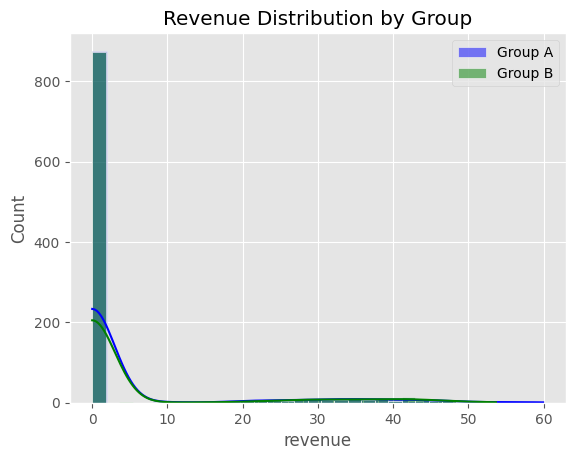

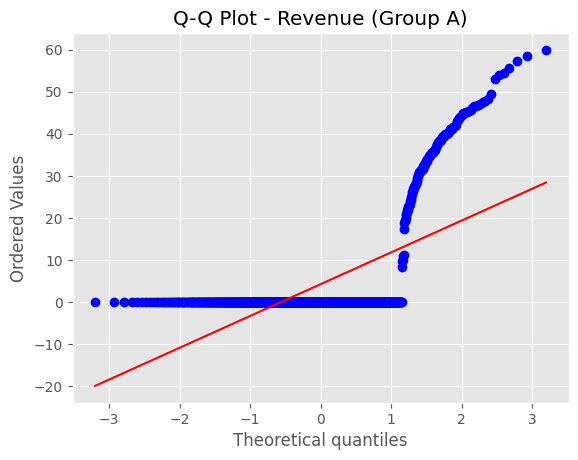

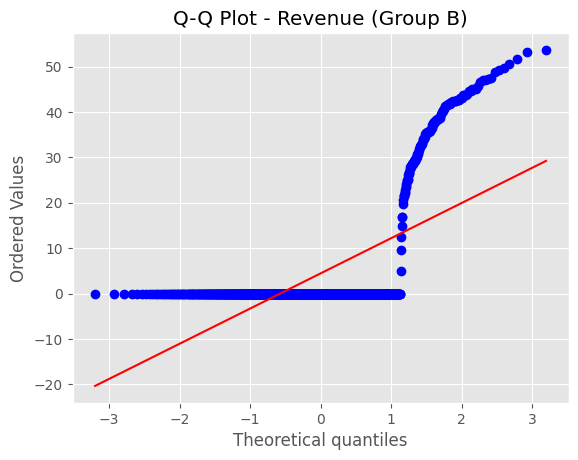

In [9]:
# Histogram
sns.histplot(group_a['revenue'], kde=True, color='blue', label='Group A', bins=30)
sns.histplot(group_b['revenue'], kde=True, color='green', label='Group B', bins=30)
plt.title("Revenue Distribution by Group")
plt.legend()
plt.show()

# Q-Q Plot
stats.probplot(group_a['revenue'], dist="norm", plot=plt)
plt.title("Q-Q Plot - Revenue (Group A)")
plt.show()

stats.probplot(group_b['revenue'], dist="norm", plot=plt)
plt.title("Q-Q Plot - Revenue (Group B)")
plt.show()


#### Histogram: Revenue Distribution by Group
- Both Group A and Group B show a heavily right-skewed distribution.

- The majority of users have low (to no) revenue (spending) values, with a long tail of users spending significantly more.

- The distributions of both groups look very similar in shape, with slight variation in the higher-value outliers.

- The visible skewness suggests that revenue data is not normally distributed.

#### Q-Q Plot: Revenue (Group A & Group B)

- The Q-Q plots for both groups deviate substantially from the red diagonal line, especially in the upper quantiles.

- A clear curve appears at the top-right corner of both plots, indicating that the tails are heavier than a normal distribution.

- There are large gaps and flat spots near the origin, due to the large number of users with zero revenue (spending).

- Overall, these plots confirm significant deviation from normality in both groups.

## Hypothesis Testing: Revenue (Mann-Whitney U Test)

In [10]:
# Split Revenue data for each group
group_a_revenue = df[df['group'] == 'A']['revenue']
group_b_revenue = df[df['group'] == 'B']['revenue']

# Perform Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(group_a_revenue, group_b_revenue, alternative='two-sided')

print("Mann-Whitney U Test Results")
print(f"U-statistic: {u_stat:.2f}")
print(f"P-value: {p_value:.4f}")


Mann-Whitney U Test Results
U-statistic: 497679.00
P-value: 0.7553


- The Mann-Whitney U test returned a U-statistic of 497,679 with a p-value of 0.7553, which is well above the common 0.05 threshold.

- This means we fail to reject the null hypothesis, and conclude that there is no statistically significant difference in revenue distributions between Group A and Group B.

- In simple terms, any observed difference in revenue is likely due to random variation and not due to the experiment or group assignment.

## Hypothesis Testing: Session Duration (T-Test)

In [11]:
# Performing a two-sided (independent) t-test
t_stat, p_val = ttest_ind(
    df[df['group'] == 'A']['session_duration'],
    df[df['group'] == 'B']['session_duration'],
    equal_var=False  # Welch's t-test (recommended when variances might differ)
)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_val:.4f}")


T-statistic: -9.17
P-value: 0.0000


- The p-value is far below 0.05, thus we have to reject the null hypothesis. Meaning that the difference in session durations between Group A and Group B is statistically significant.

- The negative t-statistic sindicates that Group A had shorter sessions on average compared to Group B (as already established in the descriptive statistics).

## Pages Viewed: Normality Test & Evaluation Method Selection

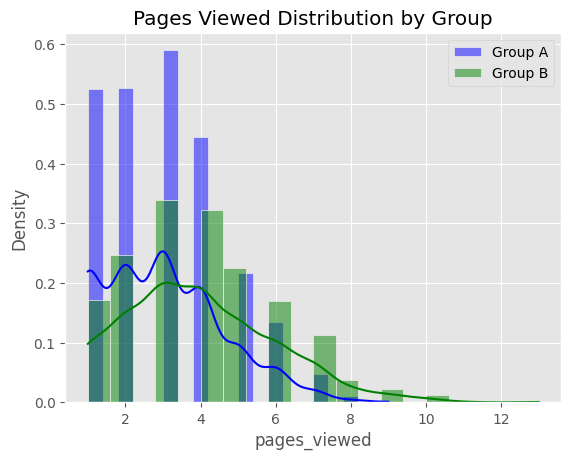

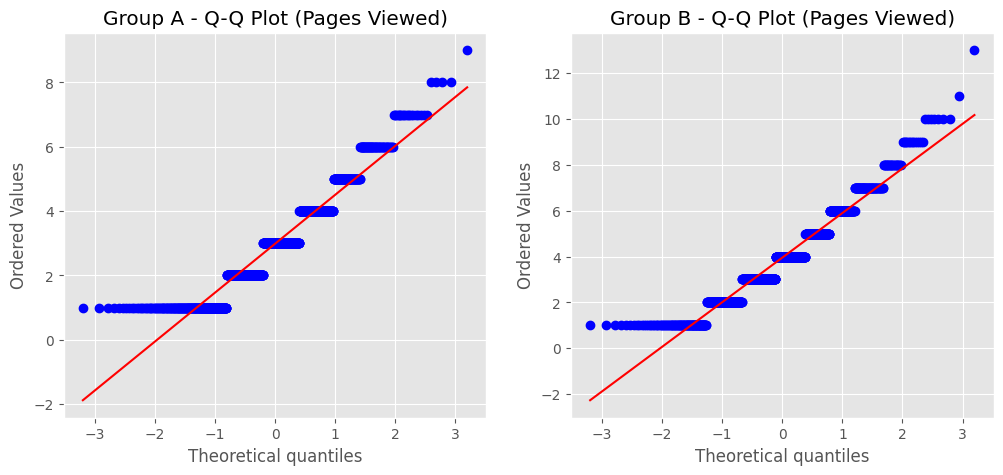

In [12]:
# Plotting the histograms for both groups
sns.histplot(df[df['group'] == 'A']['pages_viewed'], kde=True, color='blue', label='Group A', stat='density')
sns.histplot(df[df['group'] == 'B']['pages_viewed'], kde=True, color='green', label='Group B', stat='density')
plt.legend()
plt.title('Pages Viewed Distribution by Group')
plt.show()

# Plotting the Q-Q Plots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
stats.probplot(df[df['group'] == 'A']['pages_viewed'], dist="norm", plot=ax[0])
ax[0].set_title('Group A - Q-Q Plot (Pages Viewed)')
stats.probplot(df[df['group'] == 'B']['pages_viewed'], dist="norm", plot=ax[1])
ax[1].set_title('Group B - Q-Q Plot (Pages Viewed)')
plt.show()

#### Histogram: Pages Viewed Distribution by Group

- Both groups show a right-skewed distributio, i.e. most users in both groups viewed only a few pages, with frequency dropping as the number of pages increases.

- Group A has a sharper peak around 2–3 pages, indicating more users view very few pages (compared to Group B).

- Group B has a broader distribution, with a slightly longer tail, suggesting some users explored more pages (compared to Group A).

- Group B’s curve is flatter and more spread out compared to Group A.

#### Q-Q Plot: Pages Viewed (Group A & Group B)

- Group A's points follow the line more closely at the start but deviate at the upper quantiles (tail), confirming right skewness.

- Group B's points also shows right skew, with heavier deviation at the higher quantiles, but the deviation appears stronger than in Group A.

- Neither distribution of each group appears perfectly normal, especially at the tails, which supports using non-parametric tests if needed.

In [13]:
# Testing for normality of distribution using Shapiro-Wilk test

a_stat, a_p = stats.shapiro(df[df['group'] == 'A']['pages_viewed'])
b_stat, b_p = stats.shapiro(df[df['group'] == 'B']['pages_viewed'])

print("Shapiro-Wilk Normality Test for Pages viewed:")
print(f"Group A: W={a_stat:.4f}, p={a_p:.4f}")
print(f"Group B: W={b_stat:.4f}, p={b_p:.4f}")


Shapiro-Wilk Normality Test for Pages viewed:
Group A: W=0.9175, p=0.0000
Group B: W=0.9459, p=0.0000


- Both groups have p-values < 0.05, which means that we have to reject the null hypothesis of normality.

- The results of the Mann-Whitney U test confirm what we observed in the Q-Q plots, i.e. that the Pages Viewed are not normally distributed for either group.

- Thus, we should proceed with a non-parametric test for hypothesis testing, i.e. Mann-Whitney U Test instead of a t-test.

In [14]:
# Split pages_viewed data for each group
group_a_pages = df[df['group'] == 'A']['pages_viewed']
group_b_pages = df[df['group'] == 'B']['pages_viewed']

# Perform Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(group_a_pages, group_b_pages, alternative='two-sided')

# Print results
print("Mann-Whitney U Test Results (Pages Viewed)")
print(f"U-statistic: {u_stat:.2f}")
print(f"P-value: {p_value:.4f}")


Mann-Whitney U Test Results (Pages Viewed)
U-statistic: 359477.50
P-value: 0.0000


- The p-value is far below 0.05, accordingly we reject the null hypothesis. This means the difference in pages viewed between Group A and Group B is statistically significant.

- Based on the examined distribution plots, Group B users tend to view more pages than Group A, indicating higher engagement.

## Hypothesis Testing: Conversion Rate (Two-Proportion Z-Test)

Since conversion is a binary variable, plotting and testing for "normality" is not neccessary or rather redundant. A normality test will by default return low p-values because binary data doesn’t follow a normal distribution.

Also given that conversion is a binary variable (0 or 1), and not continuous we need to use either a Chi-Square Test for Independence or a Two-Proportion Z-Test, for the hypothesis testing.

But first we will plot the conversion rate for both groups to visualize the user tendency of converting.

Group A: Conversion Rate = 0.1240
Group B: Conversion Rate = 0.1280


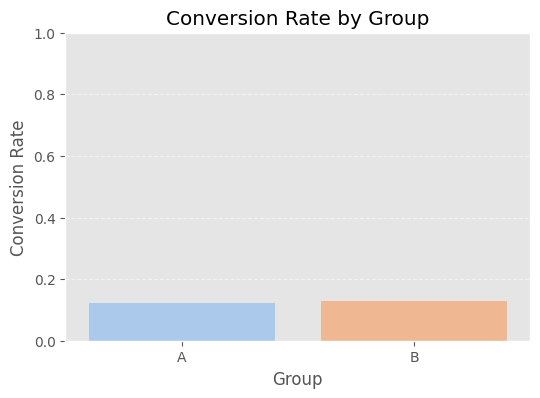

In [15]:
# Calculating conversion rates
conversion_rates = df.groupby('group')['converted'].mean().reset_index()

# Printing numeric conversion rates
for _, row in conversion_rates.iterrows():
    print(f"Group {row['group']}: Conversion Rate = {row['converted']:.4f}")

# Bar plot
plt.figure(figsize=(6, 4))
sns.barplot(data=conversion_rates, x='group', y='converted', palette='pastel', hue= 'group')

plt.title('Conversion Rate by Group')
plt.ylabel('Conversion Rate')
plt.xlabel('Group')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


- Group B has a slightly higher conversion rate than Group A.

- The absolute difference is 0.4 percentage points, which may seem small, but we need to assess if it's statistically significant.

In [18]:
group_a_conversion = group_a['converted']
group_b_conversion = group_b['converted']

# Count of conversions in each group
conversions = [
    group_a_conversion.sum(),  # successes in Group A
    group_b_conversion.sum()   # successes in Group B
]

# Total sample size for each group
n_obs = [
    group_a_conversion.count(),
    group_b_conversion.count()
]

# Perform the two-proportion z-test
z_stat, p_val = proportions_ztest(count=conversions, nobs=n_obs)

# Output the results
print("Two-Proportion Z-Test Results:")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_val:.4f}")


Two-Proportion Z-Test Results:
Z-statistic: -0.2695
P-value: 0.7875


- The p-value = 0.7875 is much greater than 0.05, thus we cannot reject the null hypothesis. Accordingly, we can conclude that there  is no statistically significant difference in conversion rates between Group A and Group B.

- Additionally, the Z-statistic = -0.2695 is very close to zero, which indicates only a dismissable difference in conversion rates between the groups, and it's not enough to be considered meaningful in a statistical sense.

## Executive Summary: A/B Test Results

In [22]:
summary_data = {
    "Metric": ["Revenue", "Session Duration", "Pages Viewed", "Conversion Rate"],
    "Statistical Test": ["Mann-Whitney U Test", "Two-Sample t-Test", "Mann-Whitney U Test", "Two-Proportion Z-Test"],
    "Significance": ["Not Significant", "Significant", "Significant", "Not Significant"],
    "Group Performance": [
        "Nearly identical",
        "Group B longer sessions",
        "Group B viewed more pages",
        "Very close (12.4% vs 12.8%)"
    ],
    "Result": [
        "No clear winner",
        "Group B better",
        "Group B better",
        "No clear winner"
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df


,Metric,Statistical Test,Significance,Group Performance,Result
0,Revenue,Mann-Whitney U Test,Not Significant,Nearly identical,No clear winner
1,Session Duration,Two-Sample t-Test,Significant,Group B longer sessions,Group B better
2,Pages Viewed,Mann-Whitney U Test,Significant,Group B viewed more pages,Group B better
3,Conversion Rate,Two-Proportion Z-Test,Not Significant,Very close (12.4% vs 12.8%),No clear winner


#### Key Inferences:

- Group B showed stronger user engagement, with significantly longer sessions and more pages viewed.

- No significant difference was found in revenue or conversion rate between the two groups, both performed similarly on these metrics.

- While conversion remained flat, the increase in user engagement for Group B may indicate better content quality, UX changes, or feature effectiveness that could have long-term value.

#### Recommendation:

- We recommend adopting Group B as the better-performing variant based on significantly stronger engagement metrics.

- Although the better user engagement didn't translate into higher conversion or revenue, these engagement improvements may boost long-term retention, brand affinity, or monetization with further optimization.